In [27]:
import pickle; import tensorflow as tf; import pandas as pd
import matplotlib.pyplot as plt ; import datetime; from datetime import datetime
#print(tf.version)
import bz2; import random; import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import warnings; from sklearn import metrics
import seaborn as sns; import itertools
warnings.filterwarnings('ignore')
###
import os; import os.path; from glob import glob
import random; import shutil
from tqdm.auto import tqdm
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
#from kerashypetune import KerasGridSearch
from numpy import mean; from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import eigh; import plotly.express as px; 

In [28]:
def FIPS_function(row):
    state = str(row['stateFip']).zfill(2)
    county = str(row['countyFip']).zfill(3)
    return str(state + county)


def get_above_threshold_2(dff,target,thresh):
    
    corr_mtrx = dff.corr(); corr_vals = corr_mtrx.values
    flds = list(corr_mtrx.columns); numCols = corr_mtrx.shape[0]
    
    above_threshold = []
    for i in range(numCols):
        for j in range(i+1, numCols):
            if corr_vals[i,j] > thresh:
                if i != j:
                    above_threshold.append([flds[i],flds[j],corr_vals[i,j]])
    above_threshold.sort(reverse=True)
    
    #above = [above.append(i) for i in above_threshold if i[0] == target or if i[1] == target:]
    list_above = []
    for i in above_threshold:
        if i[0] == target or i[1] == target:
            list_above.append(i)
            
    return corr_mtrx, list_above


def get_suggestions(dff,num,methodd):
    
    # get correlation matrix using desired method
    og_corr_mtrx = dff.corr(method=methodd); corr_vals = og_corr_mtrx.values
    flds = list(og_corr_mtrx.columns); numCols = og_corr_mtrx.shape[0]; 
    target_corrs = []; target = 'JHU_ConfirmedCases.data'
    
    # iterate throughout matrix and get all correlations associated with target
    for i in range(numCols):
        for j in range(i+1, numCols):
            if i != j:
                if flds[i] == target or flds[j] == target:
                    target_corrs.append([flds[i],flds[j],corr_vals[i,j]])
    
    # convert corrs to df, sort by correlations and keep only the number of desried rows 
    s_corrs = pd.DataFrame(target_corrs,columns=['col1','col2','corr'])
    s_corrs = s_corrs.sort_values(by='corr', ascending=False).head(num)
    s_corrs.reset_index(drop=True); suggestion_lst=[]
    
    # put the names of columns into a list
    for i, j in s_corrs.iterrows():
        if j["col1"] != target:
            suggestion_lst.append(j['col1'])
        if j['col2'] != target:
            suggestion_lst.append(j['col2'])
            
    return suggestion_lst, s_corrs, og_corr_mtrx

In [29]:
#pd.show_versions() #pandas: 1.0.5
#!pip install pandas==1.4.1 --user
#pd.show_versions() #pandas: 1.4.1

In [30]:
file_name = '/Users/evanfalkowski/Documents/Drexel/Capstone/DSCI_592/workspace/feeFiFoFum.pbz2'
bz_file = bz2.BZ2File(file_name,'rb'); df = pd.read_pickle(bz_file)
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']
df.drop(cols, axis=1, inplace=True); print(df.shape,df.isnull().sum().sum())
df = df.dropna(); df = df.reset_index(drop = True); df = df.drop(columns='dates')
print(df.shape,df.isnull().sum().sum()); df.head(3)

(1879589, 88) 380
(1879209, 87) 0


,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,...,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25
0,1.00,0.00,24527.00,5343.00,11868.00,12673.00,4924.00,9716.50,0.00,386.50,...,38.10,12191,24397,21415,179,87,39,122,2555,9.62
1,1.00,0.00,24527.00,5343.00,11868.00,12673.00,4924.00,9716.50,0.00,386.50,...,38.10,12191,24397,21415,179,87,39,122,2555,9.62
2,1.00,0.00,24527.00,5343.00,11868.00,12673.00,4924.00,9716.50,0.00,386.50,...,38.10,12191,24397,21415,179,87,39,122,2555,9.62


## PCA
- https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [31]:
target = 'JHU_ConfirmedCases.data'; features = list(df.columns);y = df.loc[:,[target]].values
x = df.loc[:, features].values; x = StandardScaler().fit_transform(x)

pca = PCA(); principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

pca_df = pd.concat([principalDf, df[[target]]], axis = 1)
var_expln = list(pca.explained_variance_ratio_);var_expln.sort(reverse=True)
print('Number of principle compnents: ', len(var_expln))
print('Original number of compnents: ', df.shape[1])

Number of principle compnents:  87
Original number of compnents:  87


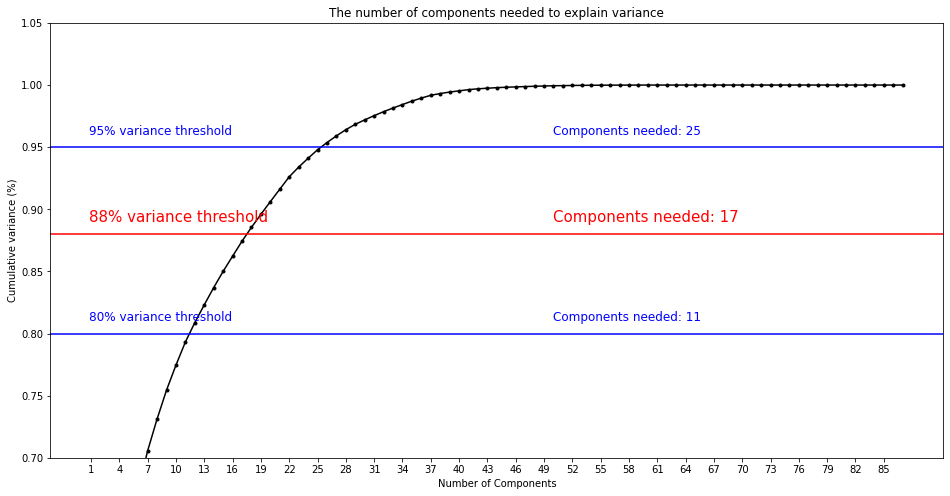

In [88]:
# Plot the cumulative variance for each component
#https://statisticallyrelevant.com/principal-component-analysis-in-python/

plt.figure(figsize = (16, 8))
components = np.arange(1, 88, step=1)
variance = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.7,1.05)
plt.plot(components, variance, marker='.', linestyle='-', color='black')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 88, step=3))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
#95%
plt.axhline(y=0.95, color='b', linestyle='-')
plt.text(0.75, 0.96, '95% variance threshold', color = 'blue', fontsize=12)
plt.text(50, 0.96, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.95)[0][0]), color = "blue", fontsize=12)
#90%
plt.axhline(y=0.88, color='r', linestyle='-')
plt.text(0.75, 0.89, '88% variance threshold', color = 'red', fontsize=15)
plt.text(50, 0.89, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.88)[0][0]), color = "red", fontsize=15)
#80%
plt.axhline(y=0.80, color='b', linestyle='-')
plt.text(0.75, 0.81, '80% variance threshold', color = 'blue', fontsize=12)
plt.text(50, 0.81, "Components needed: "+str(np.where(np.cumsum(pca.explained_variance_ratio_)>=0.80)[0][0]), color = "blue", fontsize=12)
plt.show()

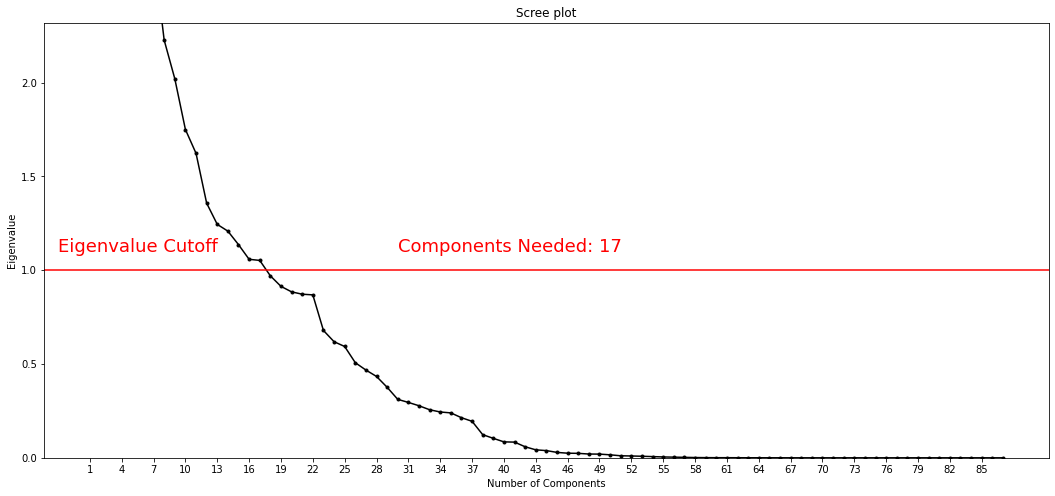

In [87]:
# Scree plot
plt.figure(figsize=(18, 8))
components = np.arange(1, 88, step=1)
eigenvalues = pca.explained_variance_
plt.plot(components, eigenvalues, marker = '.', linestyle = '-', color = 'black')
#plt.ylim(0, max(eigenvalues))
plt.ylim(0, max(eigenvalues)/16)
plt.ylabel('Eigenvalue')
plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 88, step = 3))
plt.title('Scree plot')
plt.axhline(y=1, color = 'r', linestyle = '-')
plt.text(-2, 1.1, 'Eigenvalue Cutoff', color = 'red', fontsize=18)
plt.text(30,1.1,'Components Needed: '+str(np.where(eigenvalues<=1)[0][0]),color='red',fontsize=18)
plt.show()

The above scree plot contains the eigenvalues on the y axis and the number of components 
on the x axis. A general rule of thumb, is to keep number of components that have an 
eigenvalue greater than 1. The scree plot suggests to keep 17 components. 

The eigvalues are really the pca.explained_variance, which is calculated as ratio of eigenvalue of a articular principal component (eigenvector) with total eigenvalues

## Suggestions from correlations and components

#### Pearson

In [34]:
p_suggestions, p_suggestion_df, p_corr_matrx = get_suggestions(df,17,'pearson')
print(p_suggestion_df.head(2));print('---');print(p_suggestion_df.tail(2));print('\n',p_suggestions)

                      col1                         col2  corr
0  JHU_ConfirmedCases.data     JHU_ConfirmedDeaths.data  0.96
6  JHU_ConfirmedCases.data  BLS_EmployedPopulation.data  0.78
---
                       col1              col2  corr
76  JHU_ConfirmedCases.data  unitsInStructure  0.76
66  JHU_ConfirmedCases.data     houseFamily65  0.76

 ['JHU_ConfirmedDeaths.data', 'BLS_EmployedPopulation.data', 'BLS_LaborForcePopulation.data', 'healthInsTotal', 'totalMoved', 'Female_Total_Population.data', 'TotalPopulation.data', 'latestTotalPopulation', 'Male_Total_Population.data', 'MaleAndFemale_Under18_Population.data', 'totalTrans', 'houseFamilyNo65', 'householdStructuresTotal', 'householdsTotal', 'house2+No65', 'unitsInStructure', 'houseFamily65']


### Other dimensionality techniques
 - #https://towardsdatascience.com/dimensionality-reduction-with-python-d3fac4e57c71
 - #https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
 - #https://www.learndatasci.com/tutorials/applied-dimensionality-reduction-techniques-using-python/
 - #https://statisticallyrelevant.com/principal-component-analysis-in-python/

In [35]:
X,Y = df[features], df[target]; X = X.drop(target,axis=1)

In [55]:
#### recursive feature elimination
import warnings;from sklearn.feature_selection import RFECV;from sklearn import linear_model

lr = linear_model.LinearRegression()
rfecv = RFECV(estimator=lr, step=1, scoring="neg_mean_squared_error")
rfecv.fit(X,Y); rfecv.transform(X)
print(rfecv); print(rfecv.n_features_, rfecv.n_features_in_)

RFECV(estimator=LinearRegression(), scoring='neg_mean_squared_error')
52 86


In [89]:
#dir(rfecv)

In [72]:
rfecv_suggestion = [] ### all suggested columns from above model
for i in range(rfecv.n_features_in_):
    if rfecv.support_[i] == True:
        rfecv_suggestion.append(X.columns[i])
print(len(rfecv_suggestion)); rfecv_suggestion

52


['TotalPopulation.data',
 'BLS_EmployedPopulation.data',
 'BLS_EmployedPopulation.missing',
 'BLS_UnemployedPopulation.data',
 'BLS_UnemployedPopulation.missing',
 'BLS_UnemploymentRate.missing',
 'BLS_LaborForcePopulation.data',
 'BLS_LaborForcePopulation.missing',
 'AverageDewPoint.missing',
 'AverageRelativeHumidity.missing',
 'AverageSurfaceAirPressure.missing',
 'AveragePrecipitationTotal.data',
 'AveragePrecipitationTotal.missing',
 'AveragePrecipitation.missing',
 'AverageWindDirection.missing',
 'AverageWindSpeed.missing',
 'latestTotalPopulation',
 'jhu_daily_cases',
 'jhu_daily_new_cases',
 'jhu_daily_cases_rolling_7',
 'jhu_daily_new_cases_rolling_7',
 'jhu_daily_cases_rolling_30',
 'jhu_daily_new_cases_rolling_30',
 'jhu_death_rate',
 'jhu_case_rate',
 'jhu_new_case_rate',
 'icu_beds_per_person',
 'staffed_beds_per_person',
 'licensed_beds_per_person',
 'cold_days',
 'hot_days',
 'moderate_days',
 'lt_18_percent',
 'employed_percent',
 'householdsTotal',
 'houseWith65',
 'h

In [54]:
#rfecv.feature_names_in_

In [53]:
# pearson's correlation feature selection with regression
from sklearn.feature_selection import SelectKBest, f_regression

xx = df.loc[:, features].values; xx = StandardScaler().fit_transform(xx)
yy = df.loc[:,[target]].values

f_s = SelectKBest(score_func=f_regression)
x_selected = f_s.fit_transform(xx,yy)
print('Original number of compnents: ', df.shape[1])
print('Number of suggested compnents from pearsons and regression : ', x_selected.shape[1])

Original number of compnents:  87
Number of suggested compnents from pearsons and regression :  10


In [ ]:
#from sklearn.feature_selection import mutual_info_regression

#mi_s = SelectKBest(score_func=mutual_info_regression); x_miselected = mi_s.fit_transform(xx,yy)

#print('Original number of compnents: ', df.shape[1])
#print('Number of suggested compnents from pearsons and regression : ', x_miselected.shape[1])

### Lazy Predict

In [ ]:
# trys all different regressor models 
# https://libraries.io/pypi/lazypredict
#https://thecleverprogrammer.com/2021/06/19/lazy-predict-in-python-tutorial/

In [ ]:
##lazy predict: regressor  # x & y are from above
from lazypredict.Supervised import LazyRegressor

X_lazy,Y_lazy = df[features], df[target]; X_lazy = X_lazy.drop(target,axis=1)

x_lazy = X_lazy.values; y_lazy = Y_lazy.values
x_lazy = StandardScaler().fit_transform(x_lazy)

xtrain, xtest, ytrain, ytest = train_test_split(x_lazy,y_lazy,test_size=0.2,random_state=42)

lazy_reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = lazy_reg.fit(xtrain, xtest, ytrain, ytest)
models

  0%|          | 0/42 [00:00<?, ?it/s]

In [ ]:
#pca_cor_cols = ['JHU_ConfirmedDeaths.data', 'BLS_EmployedPopulation.data', 'BLS_LaborForcePopulation.data', 'healthInsTotal', 'totalMoved', 'Female_Total_Population.data', 'TotalPopulation.data', 'latestTotalPopulation', 'Male_Total_Population.data', 'MaleAndFemale_Under18_Population.data', 'totalTrans', 'houseFamilyNo65', 'householdStructuresTotal', 'householdsTotal', 'house2+No65', 'unitsInStructure', 'houseFamily65']

#slim_x = df.loc[:, pca_cor_cols].values; slim_x = StandardScaler().fit_transform(slim_x)
#slim_y = df.loc[:,[target]].values

#slim_xtrain, slim_xtest, slim_ytrain, slim_ytest = train_test_split(slim_x, slim_y, test_size=0.2, random_state=42)

#slim__lazy_reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#slim_models, slim_predictions = slim_lazy_reg.fit(slim_xtrain, slim_xtest, slim_ytrain, slim_ytest)
#slim_models